In [1]:
import pandas as pd
import subprocess
import json

In [2]:
def skim_data(data):
    summary = pd.DataFrame({
                    'column': data.columns.values,
                    'type': data.dtypes.values,
                    'n_unique': data.nunique().values,
                    'min': data.min().values,
                    'max': data.max().values,
                    'sample_unique': [data[col].unique() for col in data.columns]
                })
    return summary

Notebook ini berisi penjelasan mengenai pemahaman dataset dari segi kelengkapan data untuk melakukan prediksi demand Capital Bikeshare.

## `1. Provided Data`

Akses dataset <a href='https://drive.google.com/file/d/1lSbp2GTSgE8jwvA2K8rlLRZIUTWNNfXe/view?usp=drive_link'>disini</a>.

In [3]:
df = pd.read_csv('../data/raw/data_bike_sharing.csv')
print(f'Jumlah baris dan kolom: {df.shape}')
display(skim_data(df))

Jumlah baris dan kolom: (12165, 11)


,column,type,n_unique,min,max,sample_unique
0,dteday,object,731,2011-01-01,2012-12-31,"[2011-12-09, 2012-06-17, 2011-06-15, 2012-03-3..."
1,hum,float64,89,0.0,1.0,"[0.62, 0.64, 0.53, 0.87, 0.55, 0.72, 0.54, 0.9..."
2,weathersit,int64,4,1,4,"[1, 2, 3, 4]"
3,holiday,int64,2,0,1,"[0, 1]"
4,season,int64,4,1,4,"[4, 2, 3, 1]"
5,atemp,float64,65,0.0,1.0,"[0.3485, 0.5152, 0.6212, 0.697, 0.4545, 0.6515..."
6,temp,float64,50,0.02,1.0,"[0.36, 0.54, 0.62, 0.76, 0.46, 0.7, 0.26, 0.82..."
7,hr,int64,24,0,23,"[16, 4, 23, 8, 18, 0, 22, 9, 5, 7, 14, 15, 21,..."
8,casual,int64,305,0,362,"[24, 2, 17, 19, 99, 6, 20, 13, 219, 1, 11, 9, ..."
9,registered,int64,742,0,876,"[226, 16, 90, 126, 758, 39, 196, 27, 5, 315, 2..."


Dataset merupakan data jumlah pengguna sepeda Capital Bikeshare di tahun 2011 dan 2012. Setiap baris data merepresentasikan informasi terkait jumlah pengguna sepeda dan kondisi cuaca pada jam tertentu di satu hari. Mengingat data bersifat time-series (setiap poin data merupakan data di waktu yang berbeda), pendekatan modeling juga akan dilakukan secara time-series. Beberapa hal yang perlu diperhatikan dalam analisis time-series adalah urutan data dan keseragaman jarak antar poin data. Data harus terurut secara waktu dari masa lalu sampai masa kini dan dua data yang berurutan memiliki jarak waktu yang sama misal satuan jam atau hari.

Mengingat dataset merupakan data jumlah pengguna sepeda pada jam tertentu di tahun 2011 dan 2012, ekspektasi dataset yang lengkap akan mempunyai jumlah poin data sebanyak: 731* hari x 24 jam = 17544 poin data. Akan tetapi, dataset yang tersedia jelas memiliki kekurangan data karena hanya terdiri dari 12165 poin data. Dataset lengkap secara hari karena unique value tanggal adalah sebanyak 731 yang sesuai dengan jumlah hari di tahun 2011 dan 2012. Dengan begitu, kekurangan data disebabkan oleh tidak lengkapnya data secara jam yang bisa dilihat lebih detail sebagai berikut.

*catatan: jumlah hari di tahun 2011 dan 2012, 365 + 366 karena tahun 2012 merupakan tahun kabisat

In [4]:
df['dteday'].value_counts().reset_index().rename(columns={'count': 'hour count'})

,dteday,hour count
0,2011-08-09,22
1,2011-02-01,22
2,2012-03-02,22
3,2012-09-29,22
4,2011-05-26,22
...,...,...
726,2011-10-26,9
727,2012-10-30,8
728,2011-01-27,7
729,2011-01-18,6


Seharusnya, setiap hari memiliki hour count sebanyak 24. Sementara itu, di dataset ini tidak ada hari yang memiliki hour count yang lengkap atau dengan kata lain, ada jam yang data jumlah pengguna sepedanya tidak tersedia. Kita akan melihat lebih lanjut sumber dataset original yang disebutkan dalam keterangan dataset (akses <a href="https://docs.google.com/document/d/1mNMpg4t6n9pKAlA0Khiivfwuv21JZVQoZ9ygvX4BI34/edit?usp=drive_link">disini</a>).

## `2. Original Data`

Akses dataset <a href='https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset'>disini</a>.

In [5]:
df_original = pd.read_csv('../data/raw/hour.csv').sort_values(by=['dteday', 'hr']).reset_index(drop=True)
print(f'Jumlah baris dan kolom: {df_original.shape}')
display(skim_data(df_original))

Jumlah baris dan kolom: (17379, 17)


,column,type,n_unique,min,max,sample_unique
0,instant,int64,17379,1,17379,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,dteday,object,731,2011-01-01,2012-12-31,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
2,season,int64,4,1,4,"[1, 2, 3, 4]"
3,yr,int64,2,0,1,"[0, 1]"
4,mnth,int64,12,1,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
5,hr,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,holiday,int64,2,0,1,"[0, 1]"
7,weekday,int64,7,0,6,"[6, 0, 1, 2, 3, 4, 5]"
8,workingday,int64,2,0,1,"[0, 1]"
9,weathersit,int64,4,1,4,"[1, 2, 3, 4]"


Dataset original ternyata masih mempunyai ketidaklengkapan data walaupun sudah lebih sedikit dari sebelumnya. Masih terdapat 17544-17379 = 165 poin data yang tidak lengkap dan kita anggap sebagai missing values untuk ditangani lebih lanjut.

## `3. Modified Data`

 Untuk data cuaca, kita akan mencari historical data cuaca per jam yang lengkap untuk tahun 2011 dan 2012 melalui salah satu platform weather forecast yang menyediakan open-source API (akses <a href='https://open-meteo.com/'>disini</a>), dengan batasan data temperatur dan kelembapan saja. Missing values yang berhubungan dengan tanggal akan mengikuti data tanggal yang sesuai. Untuk data lainnya, kita akan menggunakan pendekatan forward fill atau melakukan imputasi berdasarkan data terakhir sebelumnya yang valid, khususnya untuk jumlah pengguna sepeda dengan pertimbangan jumlah pengguna sepeda tidak berubah secara drastis setiap jamnya.

In [7]:
# reference: https://github.com/m0rp43us/openmeteopy/issues/10#issuecomment-1620424369
latitude, longitude = 38.895, -77.036
start_date, end_date = '2011-01-01', '2012-12-31'
dict_weather = subprocess.check_output(['curl', f'https://archive-api.open-meteo.com/v1/era5?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relativehumidity_2m']).decode()
dict_weather = json.loads(dict_weather)
# convert to pandas dataframe
df_weather = pd.DataFrame([dict_weather['hourly']['time'],
                           dict_weather['hourly']['temperature_2m'],
                           dict_weather['hourly']['relativehumidity_2m']],
                           index = ['datetime', 'Temperature', 'Humidity']).T
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.shape

(17544, 3)

In [8]:
df_original['datetime'] = pd.to_datetime(df_original['dteday']) + pd.to_timedelta(df_original['hr'], unit='h')

In [9]:
df_clean = df_original.merge(df_weather, on='datetime', how='outer').sort_values(by='datetime').reset_index(drop=True)

In [10]:
tmp = df_clean.isna().sum().reset_index()

In [11]:
for col in tmp[tmp[0]>0]['index']:
    df_clean[col] = df_clean[col].ffill()

<Axes: >

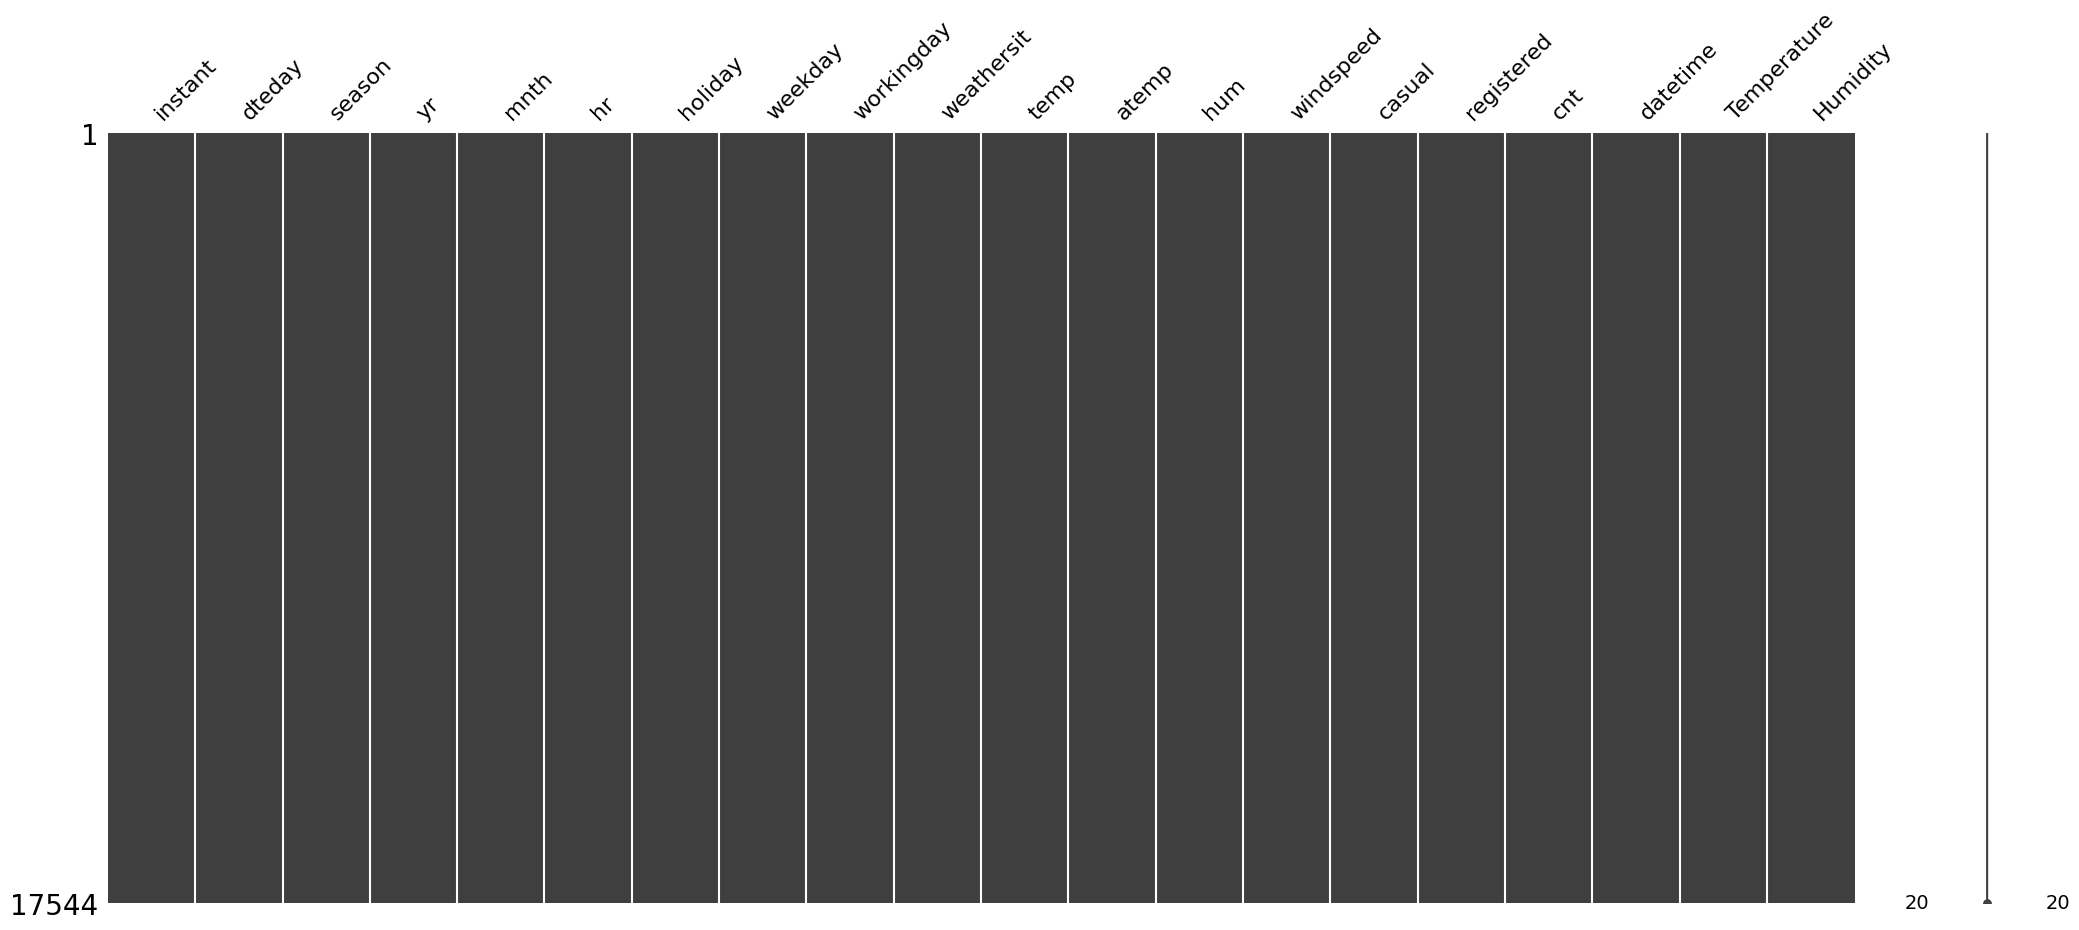

In [12]:
import missingno as msno
msno.matrix(df_clean)